# Data Understanding and Feature Engineering for Container Price Prediction

This notebook performs comprehensive analysis of our collected data and engineers the time-lagged features necessary for accurate time-series forecasting of container freight prices.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

# Set plotting style
plt.style.use("default")
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 1: Load Data

Load the cleaned freight and black swan disruption data prepared in the data collection notebook.

In [2]:
# Load freight data
try:
    df_freight = pd.read_csv("collected_freight_data.csv", parse_dates=["Date"], index_col="Date")
    print(f"✓ Loaded freight data: {len(df_freight)} records")
    print(f"  Date range: {df_freight.index.min().date()} to {df_freight.index.max().date()}")
except FileNotFoundError:
    print("✗ Error: collected_freight_data.csv not found. Run data collection notebook first.")

# Load black swan disruption data
try:
    df_news = pd.read_csv("collected_news_data.csv", parse_dates=["date"], index_col="date")
    has_news = True
    print(f"✓ Loaded black swan data: {len(df_news)} records")
    print(f"  Features: {len(df_news.columns)} disruption indicators")
except FileNotFoundError:
    has_news = False
    print("✗ Error: collected_news_data.csv not found. Run data collection notebook first.")

✓ Loaded freight data: 385 records
  Date range: 2018-01-05 to 2025-08-22
✓ Loaded black swan data: 407 records
  Features: 22 disruption indicators


## Step 2: Merge Datasets and Create Target Variable

Perform inner join on date index and create the 1-week ahead price prediction target.

In [3]:
# Merge freight and disruption data
df_combined = df_freight.join(df_news, how='inner')

# Create target variable: price 1 week ahead
df_combined['price_1w_ahead'] = df_combined['Europe_Base_Price'].shift(-1)

print("=" * 70)
print("DATA MERGING COMPLETE")
print("=" * 70)
print(f"Combined dataset: {len(df_combined)} weeks")
print(f"Date range: {df_combined.index.min().date()} to {df_combined.index.max().date()}")
print(f"Total features: {len(df_combined.columns)}")
print(f"Target: price_1w_ahead (next week's Europe Base Price)")

DATA MERGING COMPLETE
Combined dataset: 367 weeks
Date range: 2018-01-05 to 2025-08-22
Total features: 25
Target: price_1w_ahead (next week's Europe Base Price)


## Step 3: Feature Engineering - Time-Lagged Features

Critical step for time-series modeling. Create lagged versions of disruption features to capture temporal relationships.

**Lag Logic for Europe-to-Shanghai Route:**
- **Origin/Route Lags (1-3 weeks)**: Events near shipping origins affect prices quickly
  - Yemen (Red Sea), Egypt (Suez), Europe, Maritime conflicts: 1-2 weeks
- **Destination Lags (4-6 weeks)**: Asia events affect return trips and equipment
- **Global Lags (1-2 weeks)**: Black swan events have immediate global impact

In [4]:
# Create lagged features based on shipping route timing
print("Creating time-lagged features...")

# Origin/Route Lags (1-3 weeks)
if 'yemen_disruption' in df_combined.columns:
    df_combined['yemen_disruption_lag_1w'] = df_combined['yemen_disruption'].shift(1)
    df_combined['yemen_disruption_lag_2w'] = df_combined['yemen_disruption'].shift(2)

if 'egypt_disruption' in df_combined.columns:
    df_combined['egypt_disruption_lag_1w'] = df_combined['egypt_disruption'].shift(1)

if 'europe_disruption' in df_combined.columns:
    df_combined['europe_disruption_lag_1w'] = df_combined['europe_disruption'].shift(1)

if 'maritime_conflict_events' in df_combined.columns:
    df_combined['maritime_conflict_lag_1w'] = df_combined['maritime_conflict_events'].shift(1)

# Destination Lags (4-6 weeks)
if 'asia_disruption' in df_combined.columns:
    df_combined['asia_disruption_lag_4w'] = df_combined['asia_disruption'].shift(4)
    df_combined['asia_disruption_lag_6w'] = df_combined['asia_disruption'].shift(6)

# Global Lags (1-2 weeks)
if 'extreme_crisis_events' in df_combined.columns:
    df_combined['extreme_crisis_lag_1w'] = df_combined['extreme_crisis_events'].shift(1)
    df_combined['extreme_crisis_lag_2w'] = df_combined['extreme_crisis_events'].shift(2)

lag_features = [col for col in df_combined.columns if '_lag_' in col]
print(f"  Created {len(lag_features)} lagged features")
for feat in lag_features:
    print(f"    - {feat}")

# Clean dataset by dropping rows with NaN
before_clean = len(df_combined)
df_model_data = df_combined.dropna()
after_clean = len(df_model_data)

print(f"\nFinal modeling dataset: {after_clean} rows, {len(df_model_data.columns)} features")
print(f"Date range: {df_model_data.index.min().date()} to {df_model_data.index.max().date()}")
print(f"Removed {before_clean - after_clean} rows due to lagging")

Creating time-lagged features...
  Created 9 lagged features
    - yemen_disruption_lag_1w
    - yemen_disruption_lag_2w
    - egypt_disruption_lag_1w
    - europe_disruption_lag_1w
    - maritime_conflict_lag_1w
    - asia_disruption_lag_4w
    - asia_disruption_lag_6w
    - extreme_crisis_lag_1w
    - extreme_crisis_lag_2w

Final modeling dataset: 360 rows, 34 features
Date range: 2018-02-23 to 2025-08-15
Removed 7 rows due to lagging


## Step 4: Time-Series Visualization

Visualize the relationship between Europe Base Price and key disruption features over time.

KeyError: Timestamp('2021-03-23 00:00:00')

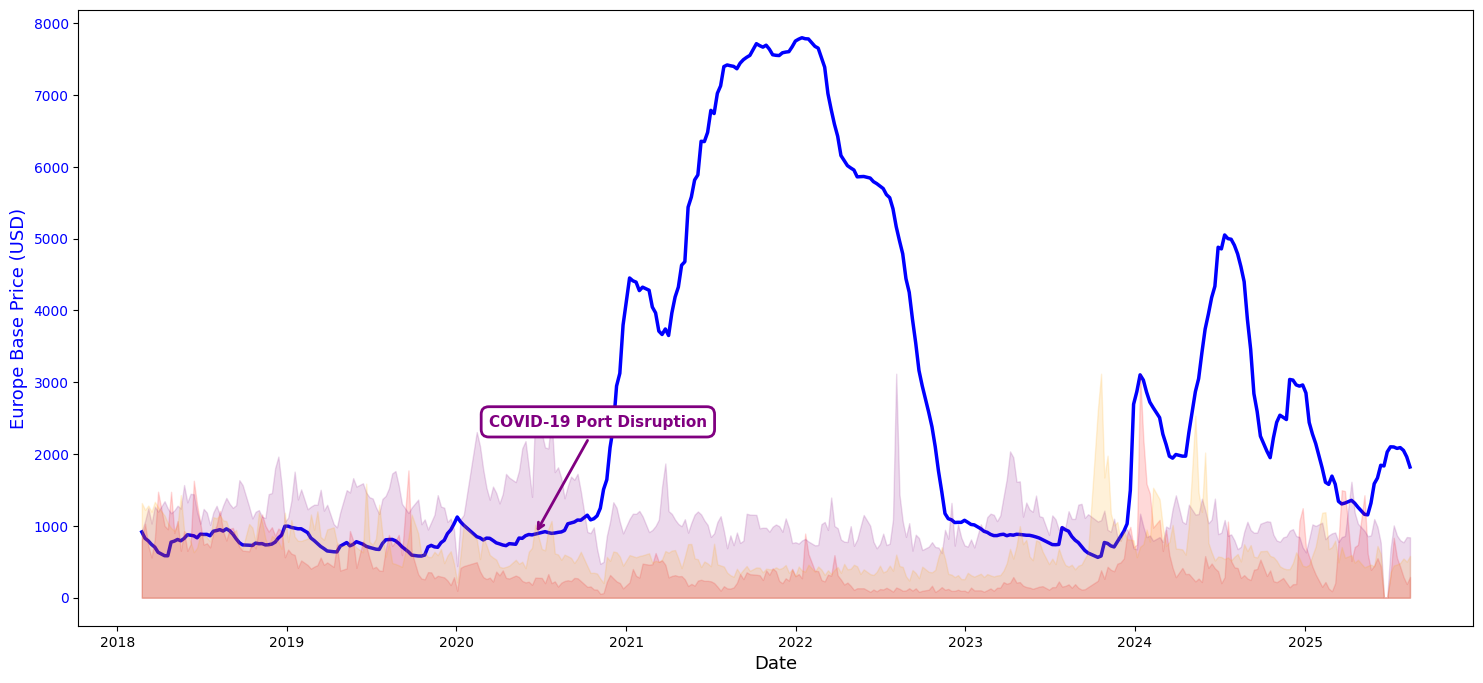

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(18, 8))

# Primary axis: Europe Base Price
color1 = 'blue'
ax1.set_xlabel('Date', fontsize=13)
ax1.set_ylabel('Europe Base Price (USD)', color=color1, fontsize=13)
ax1.plot(df_model_data.index, df_model_data['Europe_Base_Price'], 
         color=color1, linewidth=2.5, label='Europe Base Price', zorder=1)
ax1.tick_params(axis='y', labelcolor=color1)

# Plot key disruption features

# --- Yemen Disruption (Unchanged) ---
if 'yemen_disruption' in df_model_data.columns:
    yemen_max = df_model_data['yemen_disruption'].max()
    if yemen_max > 0:
        yemen_normalized = (df_model_data['yemen_disruption'] / yemen_max) * df_model_data['Europe_Base_Price'].max() * 0.4
        ax1.fill_between(df_model_data.index, 0, yemen_normalized, 
                        color='red', alpha=0.15, label='Yemen Disruption (Red Sea)', zorder=2)

# --- Asia Disruption (Unchanged) ---
if 'asia_disruption' in df_model_data.columns:
    asia_max = df_model_data['asia_disruption'].max()
    if asia_max > 0:
        asia_normalized = (df_model_data['asia_disruption'] / asia_max) * df_model_data['Europe_Base_Price'].max() * 0.4
        ax1.fill_between(df_model_data.index, 0, asia_normalized, 
                        color='purple', alpha=0.15, label='Asia Disruption (COVID-19)', zorder=2)

# --- Egypt Disruption (Unchanged) ---
if 'egypt_disruption' in df_model_data.columns:
    egypt_max = df_model_data['egypt_disruption'].max()
    if egypt_max > 0:
        egypt_normalized = (df_model_data['egypt_disruption'] / egypt_max) * df_model_data['Europe_Base_Price'].max() * 0.4
        ax1.fill_between(df_model_data.index, 0, egypt_normalized, 
                        color='orange', alpha=0.15, label='Egypt Disruption (Suez)', zorder=2)

# --- Annotations for major events ---

# --- Annotation for COVID-19 (Unchanged) ---
covid_peak = df_model_data[(df_model_data.index >= '2020-03-01') & (df_model_data.index <= '2021-12-31')]
if not covid_peak.empty and 'asia_disruption' in covid_peak.columns:
    covid_max_idx = covid_peak['asia_disruption'].idxmax() 
    covid_price = covid_peak.loc[covid_max_idx, 'Europe_Base_Price']
    ax1.annotate('COVID-19 Port Disruption', xy=(covid_max_idx, covid_price),
                xytext=(covid_max_idx - pd.Timedelta(days=100), covid_price + 1500),
                arrowprops=dict(arrowstyle='->', color='purple', lw=2),
                fontsize=11, fontweight='bold', color='purple',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='purple', linewidth=2))

# ===================================================================
# FIXED SECTION
# This now finds the Friday *within* the blockage week (2021-03-23 to 2021-03-29)
# instead of looking for the exact (non-existent) start date.
# ===================================================================
suez_start_date = pd.Timestamp('2021-03-23')
suez_end_date = pd.Timestamp('2021-03-29')

# Find the row(s) *within* that week
suez_data_slice = df_model_data.loc[suez_start_date:suez_end_date]

if not suez_data_slice.empty:
    # Get the actual Friday index and price from that slice
    suez_friday_date = suez_data_slice.index[0] # This will be '2021-03-26'
    suez_price_point = suez_data_slice['Europe_Base_Price'].iloc[0] # Get price from that row

    # Point the arrow at the *actual* data point
    ax1.annotate('Suez Canal Blockage', xy=(suez_friday_date, suez_price_point),
                xytext=(suez_friday_date - pd.Timedelta(days=300), suez_price_point + 1000), 
                arrowprops=dict(arrowstyle='->', color='orange', lw=2),
                fontsize=11, fontweight='bold', color='orange',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='orange', linewidth=2))
# ===================================================================

# --- Annotation for Red Sea Crisis (Unchanged) ---
red_sea_start = pd.Timestamp('2023-10-20')
if any(df_model_data.index >= red_sea_start):
    red_sea_data = df_model_data[df_model_data.index >= red_sea_start]
    if not red_sea_data.empty and 'yemen_disruption' in red_sea_data.columns:
        red_sea_max_idx = red_sea_data['yemen_disruption'].idxmax()
        red_sea_price = red_sea_data.loc[red_sea_max_idx, 'Europe_Base_Price']
        ax1.annotate('Red Sea Crisis', xy=(red_sea_max_idx, red_sea_price),
                    xytext=(red_sea_max_idx - pd.Timedelta(days=150), red_sea_price - 200),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2),
                    fontsize=11, fontweight='bold', color='red',
                    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='red', linewidth=2))

plt.title('Europe Base Price vs Black Swan Events', fontsize=16, fontweight='bold', pad=20)
ax1.legend(loc='upper left', fontsize=11, framealpha=0.95)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 5: Predictive Correlation Analysis

**Most important analysis** - showing which lagged features correlate with future price movements.

PREDICTIVE FEATURE CORRELATIONS WITH FUTURE PRICE

Features ranked by correlation strength with price_1w_ahead:
maritime_conflict_lag_1w   -0.214541
yemen_disruption_lag_1w    -0.215474
yemen_disruption_lag_2w    -0.221412
asia_disruption_lag_6w     -0.318196
asia_disruption_lag_4w     -0.328976
egypt_disruption_lag_1w    -0.338420
europe_disruption_lag_1w   -0.368889
extreme_crisis_lag_1w      -0.417323
extreme_crisis_lag_2w      -0.419014
Name: price_1w_ahead, dtype: float64


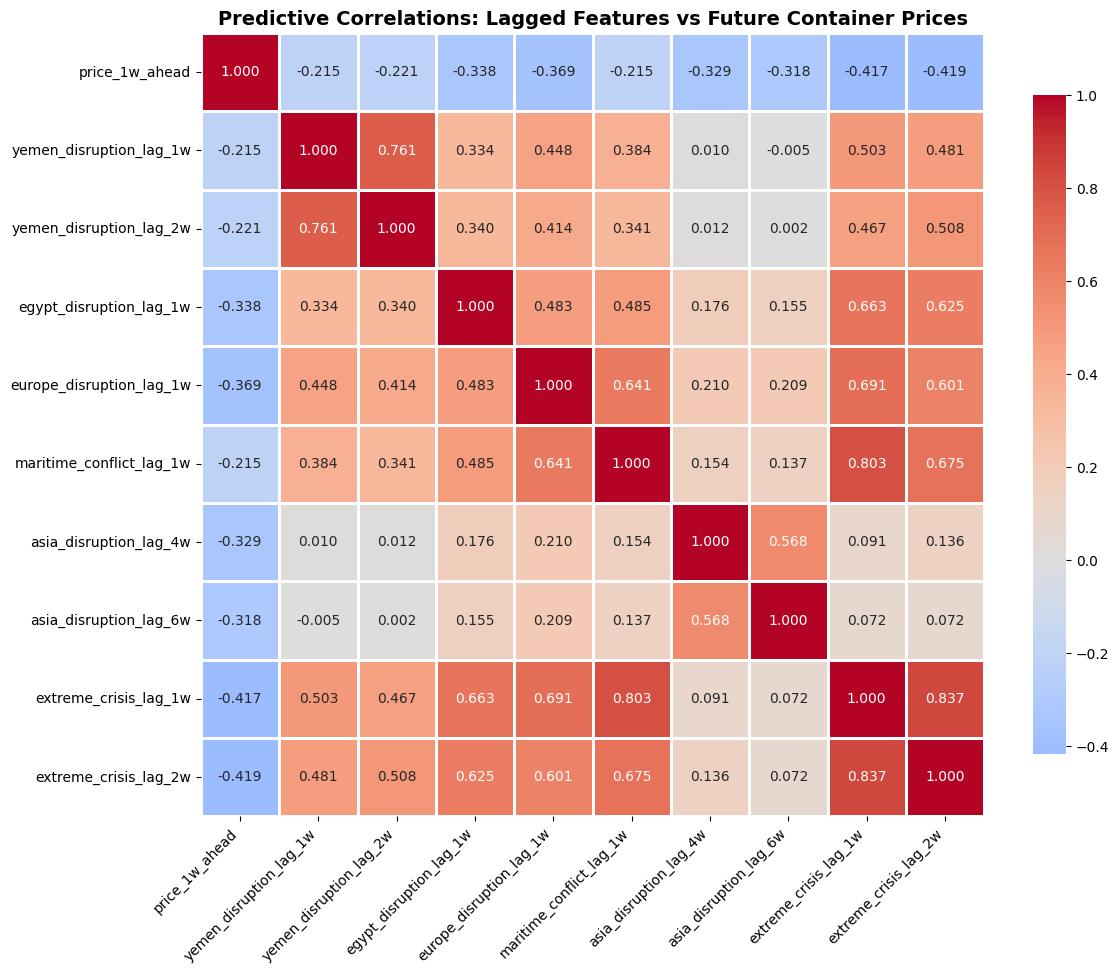


INTERPRETATION GUIDE
• Strong correlation (|r| > 0.5): Feature strongly predicts price changes
• Moderate correlation (|r| > 0.3): Useful predictive feature
• Weak correlation (|r| < 0.2): Little predictive value

This validates which lagged disruption features are truly predictive!


In [6]:
# Correlation matrix for target and lagged features
predictive_features = ['price_1w_ahead'] + lag_features
correlation_data = df_model_data[predictive_features].corr()
target_correlations = correlation_data['price_1w_ahead'].drop('price_1w_ahead')

print("=" * 70)
print("PREDICTIVE FEATURE CORRELATIONS WITH FUTURE PRICE")
print("=" * 70)
print("\nFeatures ranked by correlation strength with price_1w_ahead:")
print(target_correlations.sort_values(ascending=False))

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Predictive Correlations: Lagged Features vs Future Container Prices', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("INTERPRETATION GUIDE")
print("=" * 70)
print("• Strong correlation (|r| > 0.5): Feature strongly predicts price changes")
print("• Moderate correlation (|r| > 0.3): Useful predictive feature") 
print("• Weak correlation (|r| < 0.2): Little predictive value")
print("\nThis validates which lagged disruption features are truly predictive!")

## Step 6: Stationarity Test

Test if the time series is stationary (statistical properties stable over time). Many models assume stationarity.

In [7]:
def check_stationarity(timeseries, column_name):
    print(f"\n=== Stationarity Analysis for {column_name} ===")
    
    # Augmented Dickey-Fuller test
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                        index=['Test Statistic', 'p-value', 'Lags Used', 'Observations'])
    
    print('\nAugmented Dickey-Fuller Test Results:')
    print(dfoutput)
    
    print('\nCritical Values:')
    for key, value in dftest[4].items():
        print(f'  {key}: {value:.3f}')
    
    # Interpretation
    print('\nInterpretation:')
    if dfoutput['p-value'] <= 0.05:
        print(f"  p-value = {dfoutput['p-value']:.4f} (< 0.05)")
        print("  Result: Series is STATIONARY (good for modeling)")
    else:
        print(f"  p-value = {dfoutput['p-value']:.4f} (> 0.05)")
        print("  Result: Series is NON-STATIONARY (may need differencing)")

# Check Europe Base Price stationarity
check_stationarity(df_freight['Europe_Base_Price'], 'Europe Base Price')


=== Stationarity Analysis for Europe Base Price ===

Augmented Dickey-Fuller Test Results:
Test Statistic     -2.088145
p-value             0.249308
Lags Used          17.000000
Observations      367.000000
dtype: float64

Critical Values:
  1%: -3.448
  5%: -2.869
  10%: -2.571

Interpretation:
  p-value = 0.2493 (> 0.05)
  Result: Series is NON-STATIONARY (may need differencing)


## Step 7: Disruption Events Analysis

Analyze geopolitical disruption patterns and their relationship to container prices.

GEOPOLITICAL DISRUPTION ANALYSIS

GDELT data: 407 weekly records


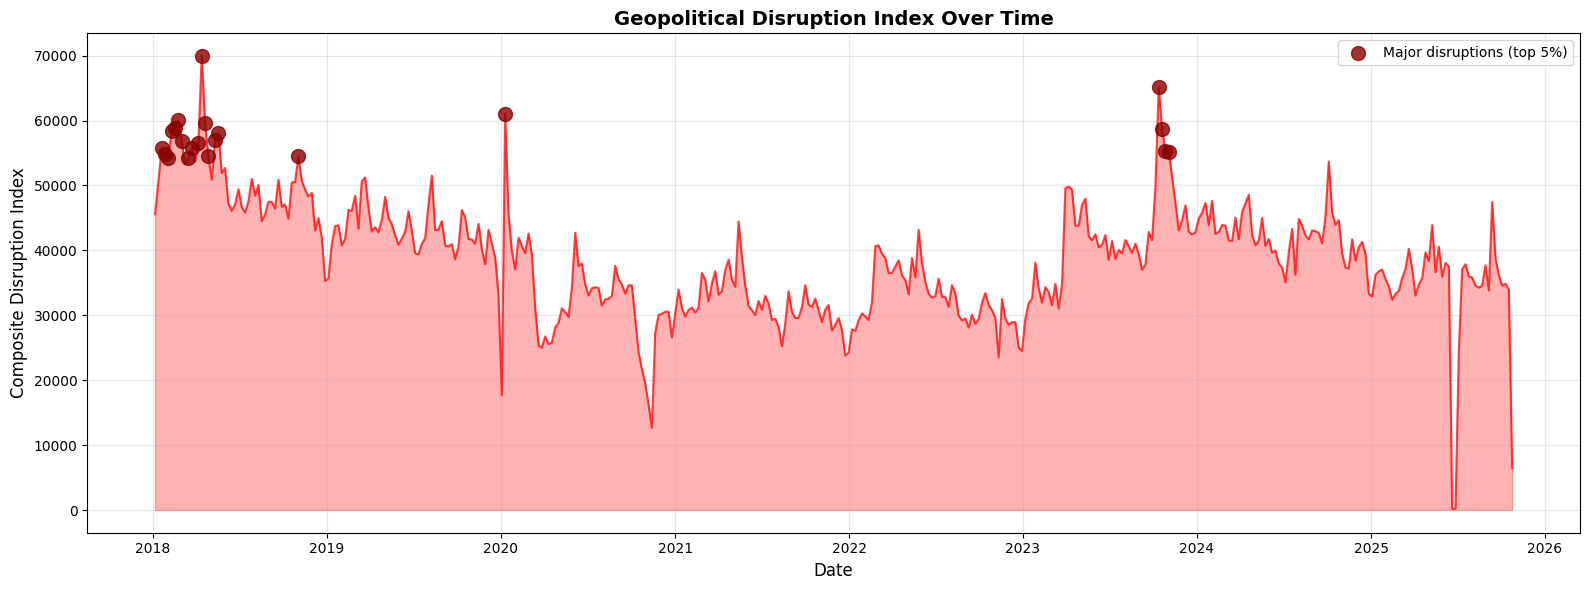


TOP 10 DISRUPTION WEEKS (Historical Black Swan Events)
            composite_disruption_index  maritime_conflict_events  extreme_crisis_events  black_swan_candidate_events
date                                                                                                                
2018-04-13                     69935.3                     27370                 205721                           20
2023-10-13                     65123.6                     23782                 193286                            8
2020-01-10                     61074.9                     25038                 178533                            9
2018-02-23                     60033.1                     34021                 166064                           19
2018-04-20                     59660.4                     27749                 171107                            9
2018-02-16                     58837.4                     33841                 162253                           23
2023-10-

In [8]:
if has_news:
    # Create composite disruption index
    df_news['composite_disruption_index'] = (
        df_news['extreme_crisis_events'] * 0.3 +
        df_news['maritime_conflict_events'] * 0.3 +
        df_news['black_swan_candidate_events'] * 0.4
    )
    
    print("=" * 70)
    print("GEOPOLITICAL DISRUPTION ANALYSIS")
    print("=" * 70)
    print(f"\nGDELT data: {len(df_news)} weekly records")
    
    # Disruption over time
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(df_news.index, df_news['composite_disruption_index'], 
            linewidth=1.5, color='red', alpha=0.7)
    ax.fill_between(df_news.index, 0, df_news['composite_disruption_index'], 
                     alpha=0.3, color='red')
    
    # Highlight major disruptions
    threshold_95 = df_news['composite_disruption_index'].quantile(0.95)
    major_disruptions = df_news[df_news['composite_disruption_index'] > threshold_95]
    ax.scatter(major_disruptions.index, major_disruptions['composite_disruption_index'],
               color='darkred', s=100, alpha=0.8, label=f'Major disruptions (top 5%)', zorder=5)
    
    ax.set_title('Geopolitical Disruption Index Over Time', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Composite Disruption Index', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Top disruption weeks
    print("\n" + "=" * 70)
    print("TOP 10 DISRUPTION WEEKS (Historical Black Swan Events)")
    print("=" * 70)
    top_disruptions = df_news.nlargest(10, 'composite_disruption_index')[[
        'composite_disruption_index', 'maritime_conflict_events', 
        'extreme_crisis_events', 'black_swan_candidate_events'
    ]]
    print(top_disruptions.to_string())
    
    print("\nExpected major events (2018-2025):")
    print("  • COVID-19 pandemic (2020-2021): Supply chain disruptions")
    print("  • Suez Canal blockage (March 2021): Ever Given incident")
    print("  • Russia-Ukraine war (Feb 2022+): Grain exports, fuel")
    print("  • Israel-Hamas conflict (Oct 2023+): Red Sea disruptions")
else:
    print("No disruption data available.")

## Step 8: Summary and Next Steps

In [9]:
print("=" * 70)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 70)

print(f"\nModeling Dataset Ready:")
print(f"  • {len(df_model_data)} training samples")
print(f"  • {len(lag_features)} predictive lagged features")
print(f"  • Target: price_1w_ahead (1-week ahead prediction)")

print(f"\nKey Features Engineered:")
print(f"  • Origin/Route lags: Yemen, Egypt, Europe, Maritime (1-2 weeks)")
print(f"  • Destination lags: Asia disruption (4-6 weeks)")
print(f"  • Global lags: Black swan events (1-2 weeks)")

print(f"\nTop Predictive Features:")
top_features = target_correlations.abs().sort_values(ascending=False).head(5)
for feature, corr in top_features.items():
    direction = "increases" if target_correlations[feature] > 0 else "decreases"
    print(f"  • {feature}: {target_correlations[feature]:.3f} (predicts price {direction})")

print(f"\nData Quality:")
print(f"  • Price range: ${df_model_data['Europe_Base_Price'].min():.2f} to ${df_model_data['Europe_Base_Price'].max():.2f}")
print(f"  • Price volatility (std): ${df_model_data['Europe_Base_Price'].std():.2f}")
print(f"  • No missing values")

print(f"\nNext Steps:")
print(f"  • Proceed to model development (03_model_development.ipynb)")
print(f"  • Train time-series models (LSTM, XGBoost) using df_model_data")
print(f"  • Focus on top correlated lagged features")
print(f"  • Validate predictions on holdout test set")

print("\n" + "=" * 70)

# Save the processed dataset for modeling
df_model_data.to_csv('processed_model_data.csv')
print("\n✓ Saved processed dataset to 'processed_model_data.csv'")

FEATURE ENGINEERING SUMMARY

Modeling Dataset Ready:
  • 360 training samples
  • 9 predictive lagged features
  • Target: price_1w_ahead (1-week ahead prediction)

Key Features Engineered:
  • Origin/Route lags: Yemen, Egypt, Europe, Maritime (1-2 weeks)
  • Destination lags: Asia disruption (4-6 weeks)
  • Global lags: Black swan events (1-2 weeks)

Top Predictive Features:
  • extreme_crisis_lag_2w: -0.419 (predicts price decreases)
  • extreme_crisis_lag_1w: -0.417 (predicts price decreases)
  • europe_disruption_lag_1w: -0.369 (predicts price decreases)
  • egypt_disruption_lag_1w: -0.338 (predicts price decreases)
  • asia_disruption_lag_4w: -0.329 (predicts price decreases)

Data Quality:
  • Price range: $562.00 to $7797.00
  • Price volatility (std): $2278.99
  • No missing values

Next Steps:
  • Proceed to model development (03_model_development.ipynb)
  • Train time-series models (LSTM, XGBoost) using df_model_data
  • Focus on top correlated lagged features
  • Validate pr